In [305]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [306]:
train_data_initial = pd.read_csv('flight_delays_train.csv')
test_data_initial = pd.read_csv('flight_delays_test.csv')
test_data_initial['dep_delayed_15min'] = np.NaN

train_data_initial['partition'] = 'train'
test_data_initial['partition'] = 'test'


data_initial = pd.concat([train_data_initial, test_data_initial])



In [307]:
# data_initial['flight'] = data_initial['Origin']+data_initial['Dest']
# pv=data_initial.pivot_table(index=['flight'],columns='partition',values='Month',aggfunc='count')
# pv=pv.fillna(0)
# pv = pv.reset_index()
# pv['exclude'] = np.where((pv['test']==0) & (pv['train']!=0),'yes', 'no')
# data_initial = data_initial.merge(pv[['flight','exclude']],how='left',on='flight')
# data_initial = data_initial[data_initial['exclude']=='no']
# data_initial = data_initial.drop(columns=['flight','exclude'])

In [308]:
#часы и обьеденить в категории
#избавить от кривых часов
#перевозчк+origin/dist

In [309]:
train_data_initial['dep_delayed_15min'].value_counts()

N    80956
Y    19044
Name: dep_delayed_15min, dtype: int64

In [310]:
print(data_initial.shape)
data_initial.head()

(198183, 10)


,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min,partition
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N,train
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N,train
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N,train
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N,train
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y,train


In [311]:
test_data_initial.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min,partition
0,c-7,c-25,c-3,615,YV,MRY,PHX,598,NaN,test
1,c-4,c-17,c-2,739,WN,LAS,HOU,1235,NaN,test
2,c-12,c-2,c-7,651,MQ,GSP,ORD,577,NaN,test
3,c-3,c-25,c-7,1614,WN,BWI,MHT,377,NaN,test
4,c-6,c-6,c-3,1505,UA,ORD,STL,258,NaN,test


In [312]:
def time_transform(df: pd.DataFrame) -> pd.DataFrame:
    
    time_cols = ['Month', 'DayofMonth', 'DayOfWeek']
    for col in time_cols:
        df[col] = df[col].str[2:].astype('int')
#     df['DepTime_h'] = (df['DepTime'] // 100).astype('int')
#     df['DepTime_h'] = np.where(df['DepTime_h']>=24,df['DepTime_h']-24,df['DepTime_h'])
#     df['hour_cat']=pd.cut(df['DepTime_h'], bins=6, labels=[1,2,3,4,5,6]).astype('int')
    
    return df



In [313]:
data = time_transform(data_initial)

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 198183 entries, 0 to 199999
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Month              198183 non-null  int32 
 1   DayofMonth         198183 non-null  int32 
 2   DayOfWeek          198183 non-null  int32 
 3   DepTime            198183 non-null  int64 
 4   UniqueCarrier      198183 non-null  object
 5   Origin             198183 non-null  object
 6   Dest               198183 non-null  object
 7   Distance           198183 non-null  int64 
 8   dep_delayed_15min  98183 non-null   object
 9   partition          198183 non-null  object
dtypes: int32(3), int64(2), object(5)
memory usage: 14.4+ MB


In [314]:
data['dep_delayed_15min'] = data['dep_delayed_15min'].map({'N': 0, 'Y': 1})
#data['flight'] = data['Origin']+data['Dest']
#data = data.drop(columns=['Origin','Dest'])

In [315]:
data.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min,partition
0,8,21,7,1934,AA,ATL,DFW,732,0.0,train
1,4,20,3,1548,US,PIT,MCO,834,0.0,train
2,9,2,5,1422,XE,RDU,CLE,416,0.0,train
3,11,25,6,1015,OO,DEN,MEM,872,0.0,train
4,10,7,6,1828,WN,MDW,OMA,423,1.0,train


In [316]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

def transform_categ(df: pd.DataFrame) -> pd.DataFrame:
    
    df['UC_Origin']=df['UniqueCarrier']+df['Origin']
    df['UC_Dest']=df['UniqueCarrier']+df['Dest']
    
    lbl=LabelEncoder()
    
    for col in ['UniqueCarrier','Origin','Dest','UC_Origin','UC_Dest']:
        
        df[col] = lbl.fit_transform(df[col])

        #target_encoding
#         df_categ = df[['UniqueCarrier', 'Origin','Dest','UC_Origin','UC_Dest','dep_delayed_15min']]
#         av_mean = df_categ.groupby(col).agg({'dep_delayed_15min':'mean'})
#         av_mean=av_mean.fillna(np.random())
#         av_mean_dict = dict(av_mean['dep_delayed_15min'], index=av_mean.index)
#         df[col] = df[col].map(av_mean_dict).astype('float64')
#    df['UC_Distance'] = df['Distance']*df['UniqueCarrier']
        
    
    return df

In [317]:
#не использую больше
def create_features(df):
    
    cols= list(df.columns)
    cols.remove('dep_delayed_15min')
    
    for col_one in cols:
        for col_two in cols:
            
            if col_one != col_two:
                new_col=col_one+'_'+col_two
                df[new_col]=df[col_one]*df[col_two]
    return df
            

In [318]:
data_processed=transform_categ(data)

In [319]:
print(data_processed.shape)
data_processed.head()

(198183, 12)


,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min,partition,UC_Origin,UC_Dest
0,8,21,7,1934,1,19,81,732,0.0,train,119,136
1,4,20,3,1548,19,221,175,834,0.0,train,1536,1520
2,9,2,5,1422,21,234,61,416,0.0,train,1734,1654
3,11,25,6,1015,16,80,179,872,0.0,train,1259,1305
4,10,7,6,1828,20,178,205,423,1.0,train,1595,1603


In [320]:
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV

In [321]:
train_data = data_processed[data_processed['partition']=='train']
train_data_y = train_data['dep_delayed_15min']
train_data_x = train_data.drop(columns=['dep_delayed_15min', 'partition'])

test_data = data_processed[data_processed['partition']=='test']
test_data_x = test_data.drop(columns=['dep_delayed_15min', 'partition'])

train_data.shape, test_data.shape

((98183, 12), (100000, 12))

In [322]:
#train_test_split?

In [323]:
X_train, X_hold, y_train, y_hold = train_test_split(
    train_data_x,
    train_data_y,
    test_size=0.4,
    
    stratify=train_data_y,
    random_state=20
)

In [324]:
train_data_x.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,UC_Origin,UC_Dest
0,8,21,7,1934,1,19,81,732,119,136
1,4,20,3,1548,19,221,175,834,1536,1520
2,9,2,5,1422,21,234,61,416,1734,1654
3,11,25,6,1015,16,80,179,872,1259,1305
4,10,7,6,1828,20,178,205,423,1595,1603


In [325]:
# params = {'n_estimators': [30,60,90,120],
#           'max_depth': [2,4,6,8,10],
#           'learning_rate':[0.05,0.1,0.2,0.3],
#           'gamma': [3,6,10],
#           'min_child_weight': [1,2,4,6]
    
          
#           }

#наилучшие параметры после поиска по сетке выше
params = {'gamma': [3],
          'learning_rate': [0.1],
          'max_depth': [6],
          'min_child_weight': [6],
          'n_estimators': [120]}

grid_search = GridSearchCV(estimator=XGBClassifier(random_state = 20, nthread=1), param_grid=params, cv=3, scoring='roc_auc', n_jobs=-1)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                   

In [326]:
grid_search.best_params_, grid_search.best_score_

({'gamma': 3,
  'learning_rate': 0.1,
  'max_depth': 6,
  'min_child_weight': 6,
  'n_estimators': 120},
 0.7311677514090872)

In [327]:
best_model_first = grid_search.best_estimator_

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

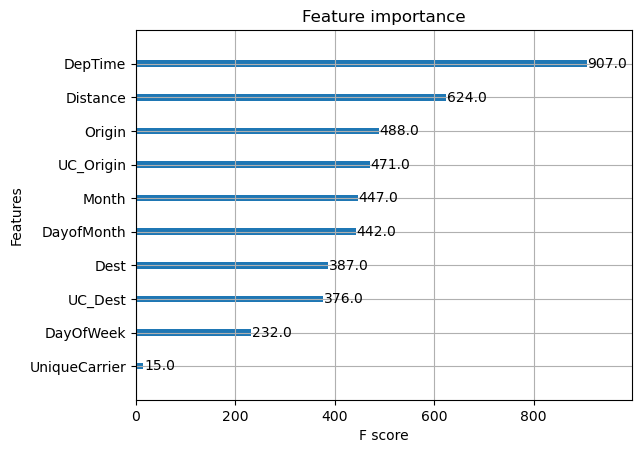

In [328]:
plot_importance(best_model_first)

In [329]:
y_pred = best_model_first.predict_proba(X_train)[:, 1]
roc_auc_score(y_train, y_pred)

0.7948008693450065

In [330]:
y_pred = best_model_first.predict_proba(X_hold)[:, 1]
roc_auc_score(y_hold, y_pred)

0.7385803989068407

In [189]:
fitted_model = best_model_first.fit(train_data_x, train_data_y)

In [190]:
y_pred = fitted_model.predict_proba(test_data_x)[:, 1]
result = pd.DataFrame(data={'dep_delayed_15min': y_pred})
result.to_csv('predict16.csv', header=True, index_label='id')

In [295]:
from sklearn.linear_model import LogisticRegression
lg = LogisticRegression(max_iter=10000,C=1)

In [299]:
scaler = StandardScaler()

In [300]:
train_data_x_scaled = scaler.fit_transform(train_data_x)

In [301]:
X_train, X_hold, y_train, y_hold = train_test_split(
    train_data_x_scaled,
    train_data_y,
    test_size=0.4,
    
    stratify=train_data_y,
    random_state=20
)

In [302]:
lg_model = lg.fit(X_train, y_train)

In [303]:
y_pred = lg_model.predict_proba(X_train)[:, 1]
roc_auc_score(y_train, y_pred)

0.6831981744416394

In [304]:
y_pred = lg_model.predict_proba(X_hold)[:, 1]
roc_auc_score(y_hold, y_pred)

0.6831264687999659